In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from tqdm import tqdm

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[0])

In [331]:
def register_add_time_property(register):
    register['STD_DD']=pd.to_datetime(register.STD_DD, format='%Y%m%d')
    
    register['year'] = register['STD_DD'].dt.year.values
    register['month'] = register['STD_DD'].dt.month.values
    register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
    register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

    register['weekday'] = np.where(register.dayofweek<5,'평일','주말')
    
    return register

In [188]:
cat_dict = {10 : '숙박',
20 : '레저용품',
21 : '레저업소',
22 : '문화취미',
30 : '가구',
31 : '전기',
32 : '주방용구',
33 : '연료판매',
34 : '광학제품',
35 : '가전',
40 : '유통업',
42 : '의복',
43 : '직물',
44 : '신변잡화',
50 : '서적문구',
52 : '사무통신',
60 : '자동차판매',
62 : '자동차 정비',
70 : '의료기관',
71 : '보건위생',
80 : '요식업소',
81 : '음료식품',
92 : '수리서비스'}

In [2]:
sk_files = [file for file in os.listdir(csv_file_path) if file.startswith('SK_melted')]
card_files = [file for file in os.listdir(csv_file_path) if file.startswith('카드')]

In [3]:
df_list_card = []

for file_name in card_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_card.append(df)

In [4]:
df_list_sk = []

for file_name in sk_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_sk.append(df)

In [10]:
register = df_list_card[1].drop(df_list_card[1].columns[0], axis=1)

with open(os.path.join(pickle_file_path,'카드_구_행정동_코드_명_변환.pickle'), 'rb') as f:
    convert_dict = pickle.load(f)

register['GU_NM'] = register.GU_CD.map(convert_dict.get('구'))
register['HDONG_NM'] = register.DONG_CD.map(convert_dict.get('행정동'))
register['MCT_CAT_NM'] = register.MCT_CAT_CD.map(cat_dict)

register = register_add_time_property(register)

register.head()

In [ ]:
with open(os.path.join(pickle_file_path,'카드_구_행정동_코드_명_변환.pickle'), 'rb') as f:
    convert_dict = pickle.load(f)

register['GU_NM'] = register.GU_CD.map(convert_dict.get('구'))
register['HDONG_NM'] = register.DONG_CD.map(convert_dict.get('행정동'))

In [13]:
fp_age= df_list_sk[0]
fp_time = df_list_sk[1]

In [68]:
def get_minNmax_fp_date(df):
    
    #설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    df_feb_2019 = df.query('year==2019 & month==2 & STD_YMD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_YMD'])['flow_counts'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_YMD'])['flow_counts'].sum())
    
    return mn2019,mx2019,mn2020,mx2020

In [333]:
def risk_index_fp(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2019,max2019,min2020,max2020 = get_minNmax_fp_date(tmp_df)
        
        tmp_df = tmp_df.groupby('STD_YMD')['flow_counts'].sum().reset_index()
        
        # min_date_index_2019 = tmp_df[tmp_df.STD_YMD == min2019].index.values[0]
        # max_date_index_2019 = tmp_df[tmp_df.STD_YMD == max2019].index.values[0]
        
        min_date_index_2020 = tmp_df[tmp_df.STD_YMD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_YMD == max2020].index.values[0]
        
        # fp_feb_2019 = tmp_df.iloc[min_date_index_2019:min_date_index_2019+7,1].sum()
        # fp_mar_2019 = tmp_df.iloc[max_date_index_2019:max_date_index_2019+7,1].sum()
        
        fp_feb_2019 = tmp_df.iloc[:28,1].mean()
        fp_mar_2019 = tmp_df.iloc[28:28+31,1].mean()
        
        fp_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,1].sum()
        fp_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,1].sum()
        
        r1 = (fp_mar_2019 - fp_feb_2019)/fp_feb_2019
        r2 = (fp_mar_2020 - fp_feb_2020)/fp_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [334]:
risk_fp = risk_index_fp(fp_time)
risk_fp

100%|███████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 28.18it/s]


{'고산1동': 0.16434175780614302,
 '고산2동': 0.14683700127673216,
 '고산3동': 0.12188458055948792,
 '공릉1동': 0.11580190981322058,
 '공릉2동': 0.161186476099745,
 '광희동': 0.22643143625665796,
 '남산1동': 0.2480224307585377,
 '남산2동': 0.35023624640543605,
 '남산3동': 0.17448727350555737,
 '남산4동': 0.10010788911926283,
 '다산동': 0.21509276750020767,
 '대봉1동': 0.14303057324373913,
 '대봉2동': 0.22114842277266433,
 '대신동': 0.30583784905608136,
 '동인동': 0.24795224564474205,
 '동화동': 0.42128369224935125,
 '두산동': 0.1394192784922983,
 '만촌1동': 0.18314637381369514,
 '만촌2동': 0.2814392636565004,
 '만촌3동': 0.1493902699675418,
 '명동': 0.2463117226525937,
 '범물1동': 0.13586474396814907,
 '범물2동': 0.09829860687624659,
 '범어1동': 0.18770667476399594,
 '범어2동': 0.28240535550614254,
 '범어3동': 0.2415832516281764,
 '범어4동': 0.4390105149218524,
 '삼덕동': 0.312531212022078,
 '상계10동': 0.10026788710594903,
 '상계1동': 0.12097645754258601,
 '상계2동': 0.18588715398880407,
 '상계3.4동': 0.03713464318237758,
 '상계5동': 0.07114612993583713,
 '상계6.7동': 0.10612803842133

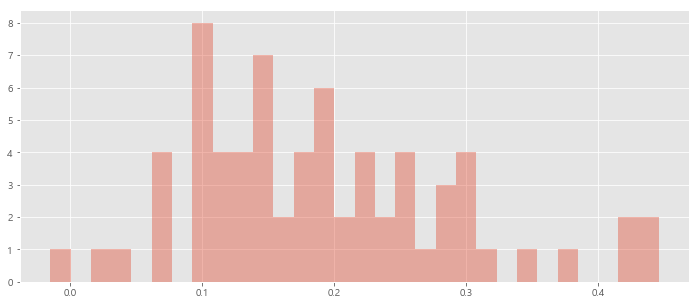

In [158]:
plt.figure(figsize=(12,5))
sns.distplot([v for i,v in risk_fp.items()], kde=False, bins=30)

In [154]:
def get_minNmax_cardAMT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_DD'])['USE_AMT'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_DD'])['USE_AMT'].sum())
    
    return mn2020,mx2020

In [310]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardAMT(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardAMT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_AMT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardAMT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardAMT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardAMT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardAMT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        cardAMT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        cardAMT_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardAMT_mar_2019 - mean_cardAMT_feb_2019)/mean_cardAMT_feb_2019
        r2 = (cardAMT_mar_2020 - cardAMT_feb_2020)/cardAMT_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [327]:
def plot_cardAMT_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    # feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
    # mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().mean()
    mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().mean()
    
    # mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
    #                      if val in range(*feb_2019_filter)])
    # mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
    #                         if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_AMT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_AMT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_AMT'
    )
    
    low, high = ax.get_ybound()

    ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5)
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5)
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24,low*1.2))
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24,low*1.2))
        
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))

In [311]:
risk_index_cardAMT(register)

100%|███████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.41it/s]


{'공릉2동': 0.16868895193129863,
 '남산1동': 0.1641202571213023,
 '남산2동': 0.22247618276842474,
 '남산3동': 0.5040495693466842,
 '남산4동': 0.039695670129803684,
 '대봉1동': 0.15995845337740655,
 '대봉2동': 0.08438731531968036,
 '대신동': 0.12914684914906682,
 '동인동': 0.40637828501511897,
 '만촌1동': 0.12691189588310237,
 '만촌2동': 0.155742798679682,
 '만촌3동': 0.21759323099375827,
 '범물1동': 0.2816913332354709,
 '범물2동': 0.03114184794677577,
 '범어1동': 0.3492457543340233,
 '범어2동': 0.14831391460800547,
 '범어3동': 0.31357997689809536,
 '범어4동': 0.13649681645513856,
 '삼덕동': 0.41510112670096233,
 '상계10동': 0.10271416036794112,
 '상계3.4동': 0.06986562222560111,
 '상계6.7동': 0.1448958839738428,
 '상계8동': 0.03956876321614322,
 '상계9동': 0.007471480203442127,
 '상동': 0.25538124975866694,
 '성내1동': 0.4067641827461501,
 '성내2동': 0.5013378838213722,
 '성내3동': 0.7529911297097143,
 '수성1가동': 0.25868379060191704,
 '수성2.3가동': 0.21686710376237173,
 '수성4가동': 0.1798443854282501,
 '신당동': 0.1210814077783402,
 '약수동': 0.04754504484053812,
 '을지로동': 0.171541